In [ ]:
!pip install transformers datasets evaluate matplotlib sentencepiece

import json
import os
import random
import torch
import spacy
import nltk
from nltk.tokenize import sent_tokenize
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import evaluate
import matplotlib.pyplot as plt

In [ ]:

# -------------------------------- CONFIG --------------------------------
input_file = "../Processed_MS_SDoH_pubmed_abstracts_with_entities.json"
train_output_file = "train.json"
model_name = "dmis-lab/biobert-base-cased-v1.1"
llama_model_id = "meta-llama/Llama-3.2-1B"  # Replace with a real PrimeKGIntegration on HuggingFace
ALLOWED_RELATIONS = ["risk_factor_for", "protective_against", "associated_with", "no_relation"]

# Set up spaCy and NLTK
nlp = spacy.load("en_core_web_sm")
nltk.download('punkt')

In [ ]:

# -------------------------------- STEP 1: LOAD DATA --------------------------------
with open(input_file, 'r', encoding='utf-8') as f:
    articles = json.load(f)

# Define a function to check if an entity is biomedical.
# For now, we consider 'Disease_disorder' as biomedical.
# If you have other categories like 'Medication' (drugs) or 'Biological_structure' (genes),
# you can add them to the conditions.
def is_biomedical_entity(e):
    if e.get('entity_group') in ['Disease_disorder']:
        return True
    # Add more conditions for other biomedical categories if needed.
    return False

def extract_candidates(article):
    abstract = article.get('abstract', '')
    if not abstract:
        return []
    sentences = sent_tokenize(abstract)
    
    # Extract biomedical entities (e.g., diseases)
    biomedical_entities = [e for e in article.get('entities', []) if is_biomedical_entity(e)]
    # Extract SDoH mentions
    sdoh_entities = article.get('sdoh_mentions', [])

    candidates = []
    for sent in sentences:
        sent_lower = sent.lower()
        # Find any SDoH mention in this sentence
        for sdoh in sdoh_entities:
            sdoh_text = sdoh['phrase']
            if sdoh_text.lower() in sent_lower:
                # If SDoH found, check if there's a biomedical entity
                for bio in biomedical_entities:
                    # The biomedical entity text may be composed from pieces (e.g., "multiple" + "##osis").
                    # In the example, 'word' is a piece of text. If the PrimeKGIntegration splits words like "multiple sclerosis"
                    # into "multiple" and "##osis", you might need to reconstruct or rely on start/end offsets.
                    # For simplicity, we will just use the 'word' field as is, but note it might not represent a full entity.
                    bio_text = bio['word']
                    # Because some entities might be split (e.g., "multiple", "##osis"), we should normalize:
                    # Combine split tokens if they belong to same entity by checking start/end indexes.
                    # For a simplified demonstration, we assume 'word' is either a complete entity or just use it as a keyword.
                    
                    # If you have multiple pieces for one entity, you'd need to merge them. For the example provided:
                    # "multiple" and "##osis" represent "multiple sclerosis".
                    # A quick hack: if entity_group == Disease_disorder and we see "multiple" and the next is "##osis",
                    # combine them into "multiple sclerosis".
                    # This is a heuristic just for demonstration:
                    if bio.get('entity_group') == 'Disease_disorder':
                        # Check if next token is "##osis" to form "multiple sclerosis"
                        # In reality, you'd need a more robust method if multiple tokens form one entity.
                        # For now, let's just handle the case found in the example.
                        if bio_text == "multiple":
                            # Look ahead for "##osis"
                            # We know entities are a list, find next entity starting right after 'multiple'
                            idx = article['entities'].index(bio)
                            if idx + 1 < len(article['entities']):
                                next_e = article['entities'][idx+1]
                                if next_e['word'] == "##osis":
                                    bio_text = "multiple sclerosis"
                    
                    if bio_text.lower() in sent_lower:
                        candidates.append((sent, sdoh_text, bio_text))
    return candidates

all_candidates = []
for article in articles:
    cands = extract_candidates(article)
    for (sent, sdoh_text, bio_text) in cands:
        all_candidates.append({
            "sentence": sent,
            "sdoh": sdoh_text,
            "biomedical_entity": bio_text
        })

print("Extracted candidate sentences with both SDoH and biomedical entities:")
for c in all_candidates[:5]:
    print(c)
# If too large, sample a subset for demonstration
all_candidates = all_candidates[:200]

In [ ]:

## Suppress transformers warnings (including pad_token_id messages)
import transformers
from tqdm import tqdm
transformers.logging.set_verbosity_error()

print("Starting LLM-based relation annotation...")

# -------------------------------- STEP 2: USE LLM TO ANNOTATE RELATIONS --------------------------------
# We'll prompt Llama to choose one of ALLOWED_RELATIONS.
llm_pipe = pipeline(
    "text-generation",
    model=llama_model_id,
    device=0 if torch.cuda.is_available() else -1,
    max_new_tokens=128,
    do_sample=False
)

def llm_classify_relation(sentence, sdoh_text, bio_text):
    prompt = f"""
You are a biomedical relation extraction assistant. We have a set of possible relationships: {ALLOWED_RELATIONS}.
Given the sentence: "{sentence}"
The first entity (SDoH) is: "{sdoh_text}"
The second entity (Biomedical) is: "{bio_text}"

Determine the best fitting relationship from {ALLOWED_RELATIONS}, or 'no_relation' if none applies.

Just output the relation label exactly.
"""
    response = llm_pipe(prompt)[0]['generated_text'].strip().lower()
    for rel in ALLOWED_RELATIONS:
        if rel in response:
            return rel
    return "no_relation"

training_data = []

# Use tqdm for a progress bar during the annotation process
for ex in tqdm(all_candidates, desc="Annotating relations", unit="example"):
    rel = llm_classify_relation(ex["sentence"], ex["sdoh"], ex["biomedical_entity"])
    training_data.append({
        "text": ex["sentence"],
        "entity1": ex["sdoh"],
        "entity2": ex["biomedical_entity"],
        "label": rel
    })

with open(train_output_file, 'w', encoding='utf-8') as f:
    json.dump(training_data, f, ensure_ascii=False, indent=4)

print(f"Training data saved to {train_output_file}")

In [ ]:

# -------------------------------- STEP 3: CREATE TRAIN/VAL SPLIT --------------------------------
# Split the generated data into train/val
random.shuffle(training_data)
split_idx = int(0.8 * len(training_data))
train_data = training_data[:split_idx]
val_data = training_data[split_idx:]

train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

In [ ]:

# -------------------------------- STEP 4: FINE-TUNE BIOBERT ON NEW DATA --------------------------------

label2id = {label: i for i, label in enumerate(ALLOWED_RELATIONS)}
id2label = {i: l for l, i in label2id.items()}

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def mark_entities(example):
    text = example["text"]
    e1 = example["entity1"]
    e2 = example["entity2"]
    start_e1 = text.lower().find(e1.lower())
    start_e2 = text.lower().find(e2.lower())
    if start_e1 == -1 or start_e2 == -1:
        # fallback: no markers if entities not found
        marked_text = text
    else:
        # ensure order
        if start_e2 < start_e1:
            (start_e1, start_e2) = (start_e2, start_e1)
            (e1, e2) = (e2, e1)
        end_e1 = start_e1 + len(e1)
        end_e2 = start_e2 + len(e2)
        marked_text = (
            text[:start_e1] + "[E1]" + text[start_e1:end_e1] + "[/E1]" +
            text[end_e1:start_e2] + "[E2]" + text[start_e2:end_e2] + "[/E2]" +
            text[end_e2:]
        )
    return {"marked_text": marked_text}

dataset = dataset.map(mark_entities)

def tokenize_fn(batch):
    # batch["marked_text"] is a list of strings
    # Run tokenizer in batched mode
    result = tokenizer(
        batch["marked_text"], 
        truncation=True, 
        padding="max_length", 
        max_length=128
    )
    
    # Convert each label in the batch to an ID
    result["labels"] = [label2id[l] for l in batch["label"]]
    return result


dataset = dataset.map(tokenize_fn, batched=True, remove_columns=["text", "entity1", "entity2", "label", "marked_text"])

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(ALLOWED_RELATIONS))
model.config.id2label = id2label
model.config.label2id = label2id

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = logits.argmax(axis=-1)
    return accuracy_metric.compute(predictions=preds, references=labels)

batch_size = 8
logging_steps = 10
output_dir = "./relation_extraction_model"

training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="steps",
    eval_steps=50,
    save_steps=50,
    logging_steps=logging_steps,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_result = trainer.train()

trainer.save_model(output_dir)

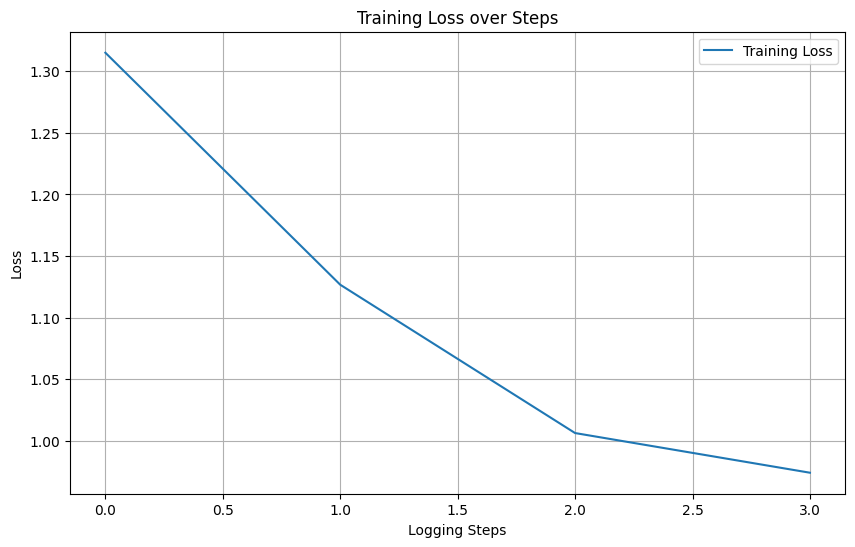

Training complete. Model saved and training loss plot generated.


In [23]:

# ------------------------- STEP 5: PLOT THE LOSS -------------------------
log_history = trainer.state.log_history
losses = [entry["loss"] for entry in log_history if "loss" in entry]
steps = range(len(losses))

plt.figure(figsize=(10,6))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.grid(True)
plt.savefig("training_loss_plot.png")
plt.show()

print("Training complete. Model saved and training loss plot generated.")
